# Import Module and Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [2]:
event_data = pd.read_csv('data/all_user_event_data.csv')
profile_data = pd.read_csv('data/all_user_profile_data.csv')
repo_data = pd.read_csv('data/all_user_repo_data.csv')
starred_data = pd.read_csv('data/all_user_starred_data.csv')

# Define Function

In [3]:
def RegressionAnalyse(X, y):
    X1 = sm.add_constant(X)
    model = sm.OLS(y, X1)
    results = model.fit()
    return results

In [4]:
def SelectNumericColumn(df):
    return df.select_dtypes(include=[np.number])

In [5]:
def PlotCorr(df, title):
    corr = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm')
    plt.title(title)
    plt.show()
    return corr

In [6]:
def PlotPercentFreq(df, field, title, xlim):
    order = df[field].value_counts().index
    total = len(df)
    sns.barplot(y=df[field].value_counts().index, x=df[field].value_counts().values/total, order=order)
    plt.title(title)
    plt.xlim(0, xlim)
    plt.show()

In [7]:
def PlotTop10LanguagePercentage(df, title, xlim):
    language_counts = df.groupby(['user_alias', 'language']).size().unstack(fill_value=0)
    total_repos = df.groupby('user_alias').size()
    language_percentages = (language_counts.T / total_repos).T * 100
    overall_language_percentages = language_percentages.mean()
    top_10_languages = overall_language_percentages.nlargest(10).index
    top_10_language_percentages = language_percentages[top_10_languages]
    melted = top_10_language_percentages.reset_index().melt(id_vars='user_alias', var_name='language', value_name='percentage')
    average_percentages = melted.groupby('language')['percentage'].mean()
    top_10_languages = average_percentages.sort_values(ascending=False).head(10).index
    top_10_melted = melted[melted['language'].isin(top_10_languages)]
    sns.barplot(data=top_10_melted, y='language', x='percentage', order=top_10_languages, errorbar=None)
    plt.title(title)
    plt.xlim(0, xlim)
    plt.show()

# Data Analysis

<b>Objective</b>: Get insights into the GitHub activity patterns of GitHub users with a high follower count.

The following steps will be undertaken to analyze the relationships:

<ul>
    <li>1. Determine if there are any disparities in the data fields between users with a high number of followers and those with fewer followers.</li>
    <li>2. If differences are found, conduct a detailed analysis to understand how these fields affect the number of followers and the nature of their influence.</li>
    <li>3. Visualize the data and perform statistical tests with a focus on significant values to better understand the patterns and trends.</li>
    <li>4. Repeat steps 1-3 for each data field.</li>
    <li>5. Compile and summarize the findings from each iteration.</li>
</ul>

## Selecting High-Follower User

In [8]:
threshold = np.exp(4) # Reasons for choosing this threshold can be found in EDA notebook
high_follower_users = profile_data[profile_data['followers'] > threshold]

In [9]:
high_follower_users.head()

,user_alias,type,hireable,location,followers,following,public_repos,public_gists,created_at,updated_at
10,usr10,User,True,Ho Chi Minh City/Viet Nam,126.0,170.0,50.0,17.0,2015-05-07T09:55:21Z,2023-12-14T15:56:05Z
29,usr29,User,NaN,The Netherlands/Rotterdam,84.0,85.0,37.0,4.0,2011-03-18T17:11:58Z,2024-01-08T20:02:08Z
61,usr61,User,NaN,Belo Horizonte - MG/Brazil,226.0,102.0,50.0,NaN,2014-12-15T20:36:44Z,2023-12-14T12:24:33Z
82,usr82,User,True,Utah,128.0,6.0,110.0,59.0,2009-02-05T20:46:03Z,2024-01-09T16:56:59Z
88,usr88,User,NaN,Eindhoven/the Netherlands,70.0,NaN,10.0,NaN,2014-02-25T18:53:32Z,2024-01-12T10:08:54Z


In [10]:
len(high_follower_users)

342

In [11]:
high_follower_aliases = high_follower_users['user_alias']

In [12]:
high_follower_aliases.head()

10    usr10
29    usr29
61    usr61
82    usr82
88    usr88
Name: user_alias, dtype: object

In [13]:
high_follower_event_data = event_data[event_data['user_alias'].isin(high_follower_aliases)]
high_follower_repo_data = repo_data[repo_data['user_alias'].isin(high_follower_aliases)]
high_follower_starred_data = starred_data[starred_data['user_alias'].isin(high_follower_aliases)]

In [14]:
low_follower_event_data = event_data[~event_data['user_alias'].isin(high_follower_aliases)]
low_follower_repo_data = repo_data[~repo_data['user_alias'].isin(high_follower_aliases)]
low_follower_starred_data = starred_data[~starred_data['user_alias'].isin(high_follower_aliases)]

## Analyze The Relationship

### Profile Data

#### Correlation Analysis

In [15]:
profile_data.head()

,user_alias,type,hireable,location,followers,following,public_repos,public_gists,created_at,updated_at
0,usr0,User,NaN,NaN,2.0,7.0,43.0,NaN,2020-09-07T23:54:51Z,2023-10-05T18:16:01Z
1,usr1,User,NaN,Tbilisi,3.0,4.0,16.0,NaN,2011-04-16T12:30:37Z,2024-01-08T13:45:16Z
2,usr2,User,NaN,Karachi,13.0,23.0,44.0,NaN,2023-01-03T13:56:42Z,2023-12-24T05:10:36Z
3,usr3,User,True,Karachi,NaN,NaN,5.0,NaN,2021-09-24T09:04:40Z,2023-05-02T19:11:00Z
4,usr4,User,NaN,NaN,1.0,NaN,2.0,NaN,2022-10-07T11:01:08Z,2023-12-07T20:03:36Z


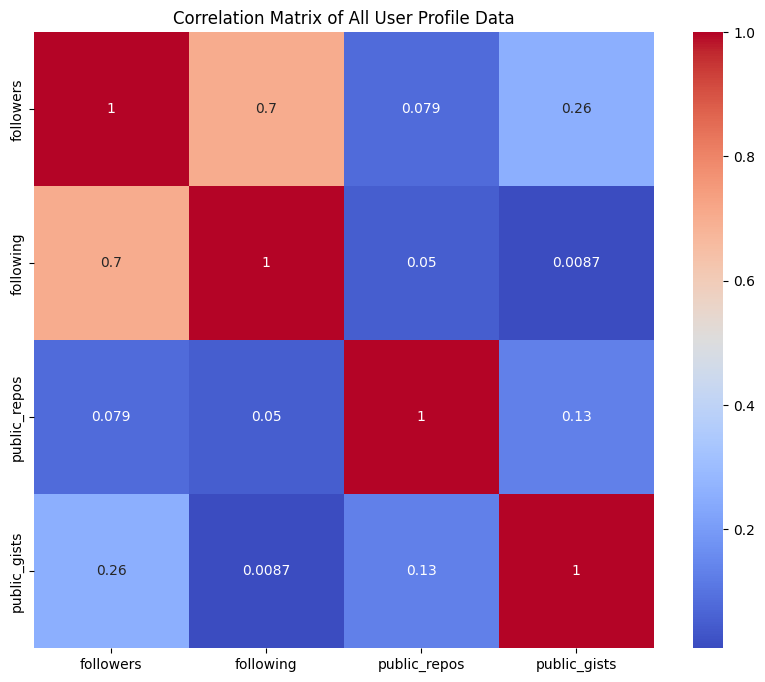

In [16]:
corr = PlotCorr(SelectNumericColumn(profile_data), title='Correlation Matrix of All User Profile Data')

In [17]:
corr

,followers,following,public_repos,public_gists
followers,1.000000,0.702345,0.079321,0.255694
following,0.702345,1.000000,0.050371,0.008656
public_repos,0.079321,0.050371,1.000000,0.129804
public_gists,0.255694,0.008656,0.129804,1.000000


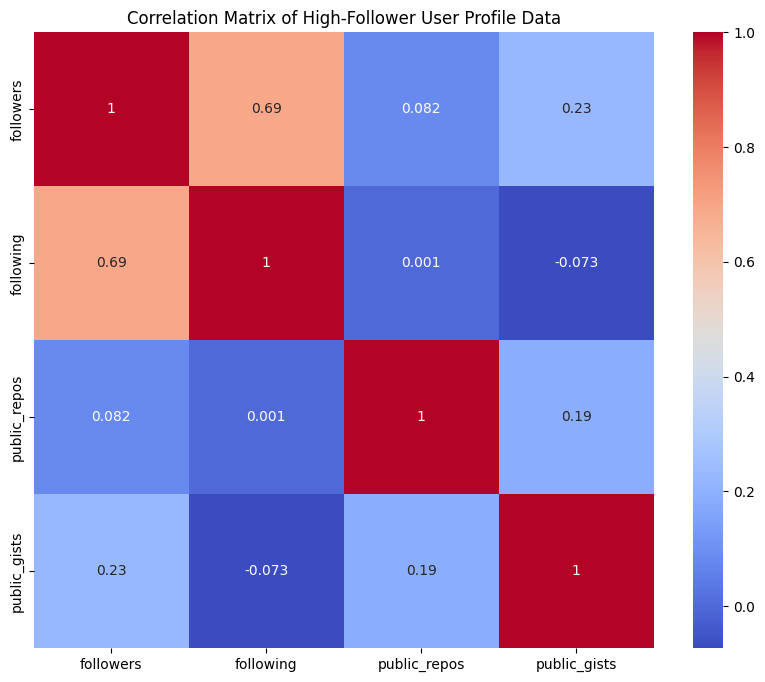

In [18]:
corr = PlotCorr(SelectNumericColumn(high_follower_users), title='Correlation Matrix of High-Follower User Profile Data')

In [19]:
corr

,followers,following,public_repos,public_gists
followers,1.000000,0.691897,0.082218,0.226252
following,0.691897,1.000000,0.001026,-0.073008
public_repos,0.082218,0.001026,1.000000,0.187655
public_gists,0.226252,-0.073008,0.187655,1.000000


By analyzing the Correlation Matrix of each field in the profile data of all users and specifically high-follower users and observing a significant correlation between the `following` and `followers` fields. A correlation coefficient of 0.702345 and 0.691897 indicates a strong positive relationship, suggesting that as the number of users one follows increases, so does the number of followers they have.

#### Regression Analysis of `following` and `followers`

In [20]:
profile_data = profile_data.dropna(subset=['following', 'followers'])

In [21]:
results = RegressionAnalyse(X = profile_data['following'], y = profile_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.493
Model:                            OLS   Adj. R-squared:                  0.493
Method:                 Least Squares   F-statistic:                     5080.
Date:                Tue, 30 Jan 2024   Prob (F-statistic):               0.00
Time:                        21:51:01   Log-Likelihood:                -35017.
No. Observations:                5220   AIC:                         7.004e+04
Df Residuals:                    5218   BIC:                         7.005e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          5.7228      2.759      2.074      0.038       0.314      11.132
following      0.8106      0.011     71.272      0.000       0.788       0.833
==============================================================================
Omnibus:                    12617.647   Durbin-Watson:                   2.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        203386733.847
Skew:                          24.720   Prob(JB):                         0.00
Kurtosis:                     968.747   Cond. No.                         244.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

R-squared = 0.493, This is a statistical measure that represents the proportion of the variance for the dependent variable that's explained by the independent variable. Meaning that approximately 49.3% of the variability in `followers` can be explained by `following`.

F-statistic = 5080, This is a measure of how significant the fit of the model is.

Prob (F-statistic) = 0.00 (The associated p-value) is less than 0.05 means that the independent variable, `following`, is a statistically significant predictor of `followers`.

coef for `following` = 0.8106, This is the change in the `followers` variable for a one-unit change in the `following` variable, holding all other variables constant. In this case, for each additional user that someone follows, their followers will increase by about 0.81.

### Event Data

#### Plot Percentage Of Event Frequency

In [22]:
event_data.head()

,user_alias,event_type,created_at
0,usr1,PushEvent,2023-10-31T17:57:39Z
1,usr1,CreateEvent,2023-10-30T18:13:26Z
2,usr1,CreateEvent,2023-10-30T17:53:32Z
3,usr2,CreateEvent,2024-01-08T17:29:08Z
4,usr2,CreateEvent,2024-01-08T17:27:38Z


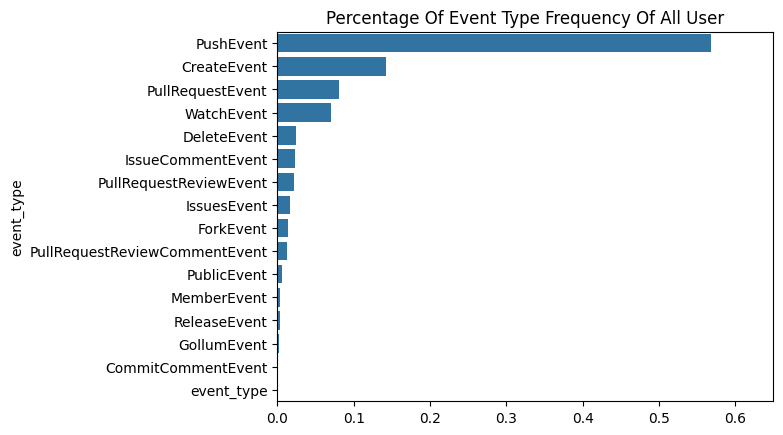

In [23]:
PlotPercentFreq(event_data, 'event_type', title='Percentage Of Event Type Frequency Of All User', xlim=0.65)

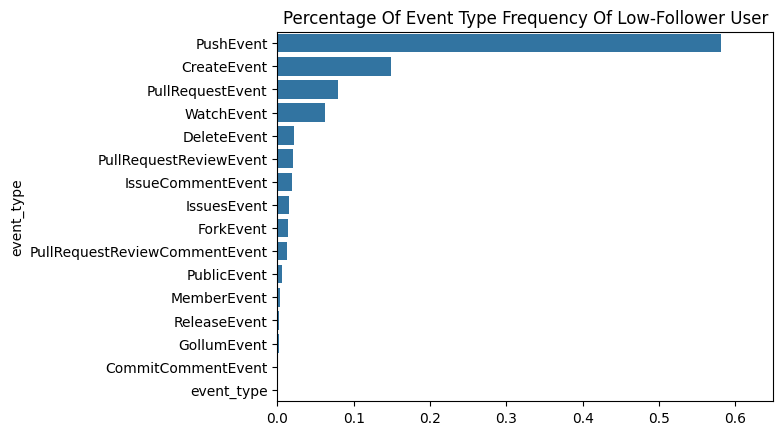

In [24]:
PlotPercentFreq(low_follower_event_data, 'event_type', title='Percentage Of Event Type Frequency Of Low-Follower User', xlim=0.65)

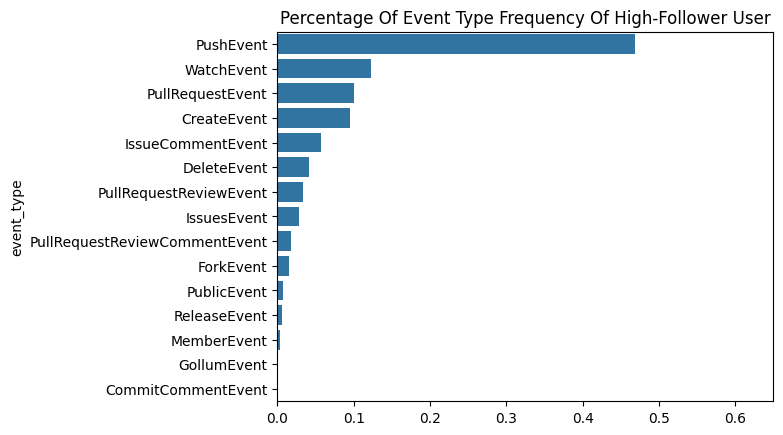

In [25]:
PlotPercentFreq(high_follower_event_data, 'event_type', title='Percentage Of Event Type Frequency Of High-Follower User', xlim=0.65)

These BarChart revealed a notable difference in the frequency of three specific event types: `PushEvent`, `CreateEvent` and `WatchEvent`.

`PushEvent` This could imply that high-follower users tend to push data to their GitHub repositories less frequently than low-follower users.

`CreateEvent` High-follower users have a lower frequency of CreateEvent compared to both low-follower users and the overall user base. This could imply that high-follower may not create new repositories as often as their low-follower counterparts.

`WatchEvent` High-follower users also have a higher frequency of WatchEvent. This indicates that they are more likely to watch or follow other users' repositories. This could be a reflection of their engagement with the GitHub community, keeping track of others' works and possibly gaining inspiration for their own projects.

#### Regression Analysis of `PushEvent`, `CreateEvent` and `WatchEvent` Frequency

In [26]:
event_counts = event_data.groupby(['user_alias', 'event_type']).size().unstack(fill_value=0)
event_counts.reset_index(inplace=True)

merged_data = pd.merge(profile_data[['user_alias', 'followers']], event_counts, on='user_alias')

In [27]:
merged_data.head()

,user_alias,followers,CommitCommentEvent,CreateEvent,DeleteEvent,ForkEvent,GollumEvent,IssueCommentEvent,IssuesEvent,MemberEvent,PublicEvent,PullRequestEvent,PullRequestReviewCommentEvent,PullRequestReviewEvent,PushEvent,ReleaseEvent,WatchEvent,event_type
0,usr1,3.0,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0
1,usr2,13.0,1,27,0,0,0,0,0,1,0,0,0,0,8,0,0,0
2,usr6,1.0,0,8,1,0,0,1,1,2,2,1,0,0,220,1,2,0
3,usr10,126.0,0,0,0,1,0,1,0,0,0,0,0,0,4,0,189,0
4,usr11,7.0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [28]:
y = merged_data['followers']

##### `PushEvent`

In [29]:
results = RegressionAnalyse(X = merged_data['PushEvent'], y = merged_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     17.56
Date:                Tue, 30 Jan 2024   Prob (F-statistic):           2.87e-05
Time:                        21:51:02   Log-Likelihood:                -20423.
No. Observations:                3017   AIC:                         4.085e+04
Df Residuals:                    3015   BIC:                         4.086e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.1933      4.476      4.511      0.000      11.417      28.970
PushEvent      0.3505      0.084      4.190      0.000       0.186       0.514
==============================================================================
Omnibus:                     7846.861   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        130197503.543
Skew:                          29.521   Prob(JB):                         0.00
Kurtosis:                    1018.985   Cond. No.                         62.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value for `PushEvent` is 2.87e-05, which is less than 0.05. Therefore, the assumption that the amount of `PushEvent` have an effects on users' follower count is statistically supported.

for each additional `PushEvent` that someone makes, their followers will increase by about 0.35.

##### `CreateEvent`

In [30]:
results = RegressionAnalyse(X = merged_data['CreateEvent'], y = merged_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     18.22
Date:                Tue, 30 Jan 2024   Prob (F-statistic):           2.03e-05
Time:                        21:51:02   Log-Likelihood:                -20423.
No. Observations:                3017   AIC:                         4.085e+04
Df Residuals:                    3015   BIC:                         4.086e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          19.5192      4.537      4.303      0.000      10.624      28.414
CreateEvent     1.6254      0.381      4.268      0.000       0.879       2.372
==============================================================================
Omnibus:                     7872.087   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        134014590.144
Skew:                          29.759   Prob(JB):                         0.00
Kurtosis:                    1033.793   Cond. No.                         14.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

The p-value for `CreateEvent` is 2.03e-05, which is also less than 0.05. Therefore, the assumption that the amount of `CreateEvent` have an effects on users' follower count is statistically supported.

for each additional `CreateEvent` that someone makes, their followers will increase by about 1.63.

##### `WatchEvent`

In [31]:
results = RegressionAnalyse(X = merged_data['WatchEvent'], y = merged_data['followers'])
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              followers   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     4.944
Date:                Tue, 30 Jan 2024   Prob (F-statistic):             0.0263
Time:                        21:51:02   Log-Likelihood:                -20430.
No. Observations:                3017   AIC:                         4.086e+04
Df Residuals:                    3015   BIC:                         4.088e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         27.3934      4.001      6.847      0.000      19.549      35.238
WatchEvent     0.6098      0.274      2.223      0.026       0.072       1.147
==============================================================================
Omnibus:                     7880.282   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        134541553.320
Skew:                          29.840   Prob(JB):                         0.00
Kurtosis:                    1035.814   Cond. No.                         15.2
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

the p-value for `WatchEvent` is 0.0263, which is also less than 0.05. Therefore, the assumption that the amount of `WatchEvent` have an effects on users' follower count is statistically supported.

for each additional `WatchEvent` that someone makes, their followers will increase by about 0.61.

### Repo Data

In [32]:
repo_data.head()

,user_alias,description,fork,stargazers_count,language,topics,forks
0,usr0,NaN,NaN,NaN,JavaScript,NaN,NaN
1,usr0,NaN,NaN,NaN,JavaScript,NaN,NaN
2,usr0,NaN,NaN,NaN,JavaScript,NaN,NaN
3,usr0,NaN,NaN,NaN,JavaScript,NaN,NaN
4,usr0,NaN,NaN,NaN,JavaScript,NaN,NaN


### Analyzing the correlation between providing repository descriptions and topics, and the follower count for all users.

In [33]:
all_users_percentages = repo_data.groupby('user_alias')[['description', 'topics']].apply(lambda x: x.notna().mean() * 100)

In [34]:
merged_data = pd.merge(profile_data[['user_alias', 'followers']], all_users_percentages, on='user_alias')

In [35]:
merged_data.head()

,user_alias,followers,description,topics
0,usr0,2.0,46.511628,0.00
1,usr1,3.0,56.250000,0.00
2,usr2,13.0,13.043478,0.00
3,usr6,1.0,52.631579,0.00
4,usr7,3.0,81.250000,6.25


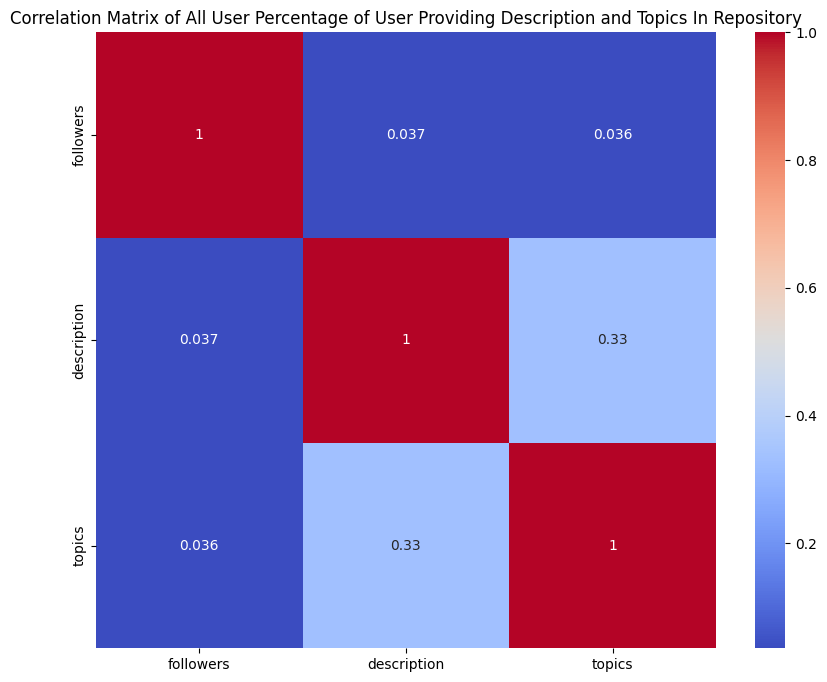

In [36]:
corr = PlotCorr(SelectNumericColumn(merged_data), title='Correlation Matrix of All User Percentage of User Providing Description and Topics In Repository')

By analyzing the correlation matrix, which encompasses the percentage of all users providing descriptions and topics, no significant correlation was found.

### Analyzing the correlation between numbers of star and forks, with the follower count for all users.

In [37]:
user_aggregates = repo_data.groupby('user_alias')[['stargazers_count', 'forks']].sum().reset_index()

In [38]:
merged_data = pd.merge(profile_data[['user_alias', 'followers']], user_aggregates, on='user_alias')

In [39]:
merged_data.head()

,user_alias,followers,stargazers_count,forks
0,usr0,2.0,0.0,0.0
1,usr1,3.0,0.0,0.0
2,usr2,13.0,13.0,0.0
3,usr6,1.0,1.0,1.0
4,usr7,3.0,4.0,0.0


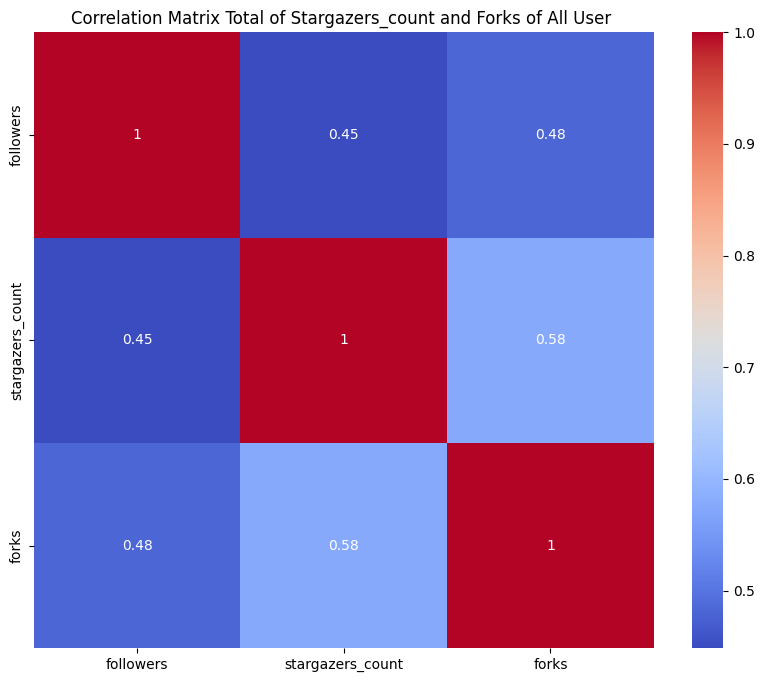

In [40]:
corr = PlotCorr(SelectNumericColumn(merged_data), title='Correlation Matrix Total of Stargazers_count and Forks of All User ')

By analyzing the correlation matrix that includes the cumulative count of stargazers and forks for all users, no significant correlation was found.

### Analyzing the percentage of each language with follower count for high-follower user and low-follower user.

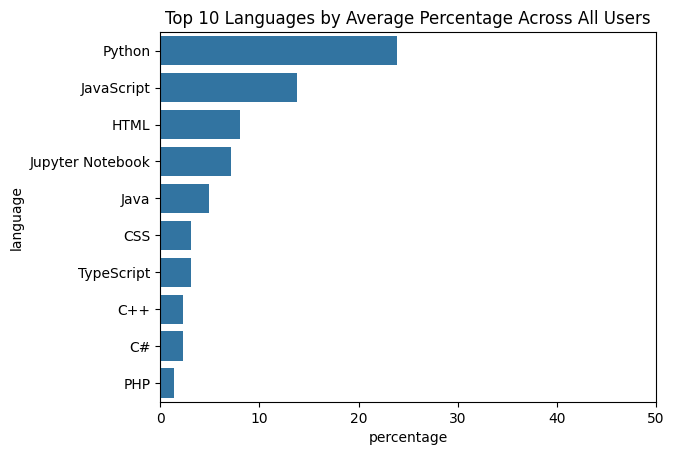

In [45]:
PlotTop10LanguagePercentage(repo_data, title = 'Top 10 Languages by Average Percentage Across All Users', xlim=50)

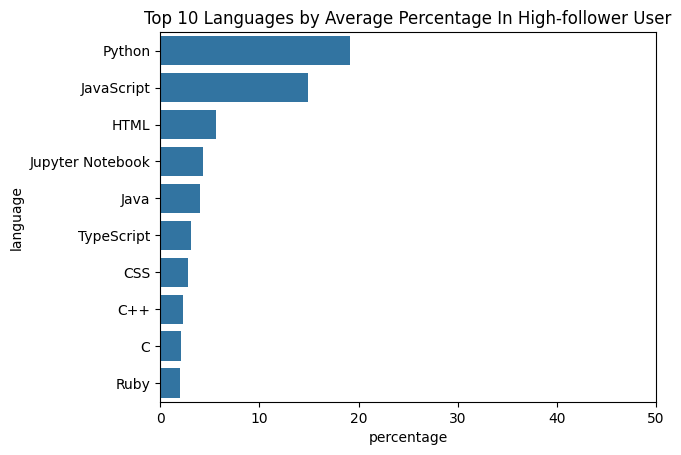

In [46]:
PlotTop10LanguagePercentage(high_follower_repo_data, title = 'Top 10 Languages by Average Percentage In High-follower User', xlim=50)

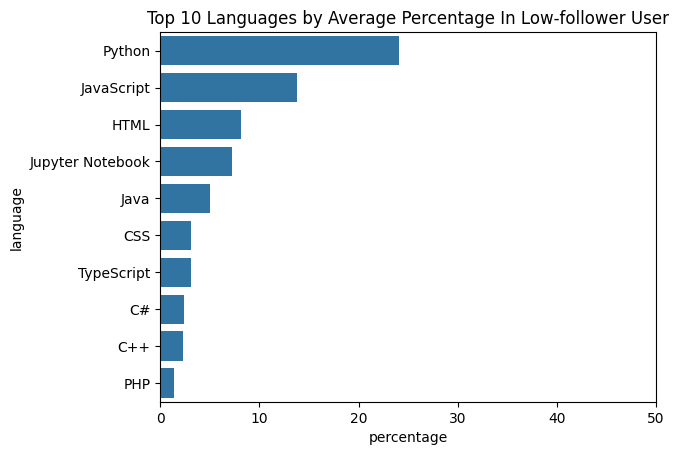

In [47]:
PlotTop10LanguagePercentage(low_follower_repo_data, title = 'Top 10 Languages by Average Percentage In Low-follower User', xlim=50)

By analyzing the top 10 languages by average percentage across all users, high-follower users, and low-follower users, it’s evident that the distribution of language usage is remarkably consistent across all three categories.

### Starred Data

In [44]:
starred_data.head()

,user_alias,full_name,html_url,description,language,topics,stargazers_count
0,usr1,microsoft/PowerToys,https://github.com/microsoft/PowerToys,Windows system utilities to maximize productivity,C#,color-picker/desktop/fancyzones/keyboard-manag...,101541.0
1,usr1,spring-projects/spring-security,https://github.com/spring-projects/spring-secu...,Spring Security,Java,framework/java/security/spring/spring-framework,8207.0
2,usr1,bitwarden/clients,https://github.com/bitwarden/clients,Bitwarden client applications (web/browser ext...,TypeScript,angular/bitwarden/browser-extension/chrome/cli...,7824.0
3,usr1,gothinkster/realworld,https://github.com/gothinkster/realworld,"""The mother of all demo apps"" — Exemplary full...",TypeScript,NaN,77396.0
4,usr1,ch4mpy/spring-addons,https://github.com/ch4mpy/spring-addons,Ease spring OAuth2 resource-servers configurat...,Java,auth0/cognito/hacktoberfest/keycloak/oidc/open...,405.0
